In [4]:
import pygame,random,gymnasium as gym,numpy as np,matplotlib.pyplot as plt
import tensorflow as tf,os,warnings
from tensorflow.keras import optimizers, losses
from tensorflow.keras import Model
from collections import deque
from tensorflow.python.framework import random_seed
from IPython.display import clear_output
warnings.filterwarnings("ignore", message="Model's `__init__()` arguments contain non-serializable objects.")

seed = 1
np.random.seed(seed)
np.random.default_rng(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
random_seed.set_seed(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
class Network(Model):
    def __init__(self, state_size: int, action_size: int, ):
        """
        Initialization.
        :param state_size: The size of the state space.
        :param action_size: The size of the action space.
        :param hidden_size: The size of the hidden layers.
        """
        super(Network, self).__init__()
        
        self.num_action = action_size
        self.layer1 = tf.keras.layers.Dense(hidden_size, activation='relu')# Define the first hidden layer with ReLU activation
        self.layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')# Define the second hidden layer with ReLU activation
        self.state = tf.keras.layers.Dense(self.num_action)# Define the output layer for state values
        self.action = tf.keras.layers.Dense(self.num_action)# Define the output layer for action values

    def call(self, state):
        """
        Forward pass of the network.
        :param state: Input state.
        :return: Value function Q(s, a).
        """
        layer1 = self.layer1(state) # Pass the input state through the first hidden layer      
        layer2 = self.layer2(layer1)  # Pass the result through the second hidden layer
        state = self.state(layer2) # Compute the state values       
        action = self.action(layer2) # Compute the action values        
        mean = tf.keras.backend.mean(action, keepdims=True)# Calculate the mean of the action values 
        advantage = (action - mean)# Calculate the advantage by subtracting the mean action value      
        value = state + advantage # Compute the final Q-values by adding state values and advantages 

        return value



episode: 2/300, score: -278.05530024698567, e: 1.0
episode: 3/300, score: -85.98054726237713, e: 0.9756
episode: 4/300, score: -183.95190529380145, e: 0.9517
episode: 5/300, score: -45.09906940210955, e: 0.9285
episode: 6/300, score: -349.55152253484584, e: 0.9058
episode: 7/300, score: -265.77311309270374, e: 0.8837
episode: 8/300, score: -102.35139253252316, e: 0.8621
episode: 9/300, score: -201.5087424116463, e: 0.8411
episode: 10/300, score: -322.8236946433825, e: 0.8205
episode: 11/300, score: -106.26115421872302, e: 0.8005
episode: 12/300, score: -121.83963487948188, e: 0.781
episode: 13/300, score: -107.44941377306334, e: 0.762
episode: 14/300, score: -147.28329235103604, e: 0.7434
episode: 15/300, score: -107.04883295049481, e: 0.7253
episode: 16/300, score: -210.07050714833292, e: 0.7076
episode: 17/300, score: -143.84793688765689, e: 0.6904
episode: 18/300, score: -117.64816669639173, e: 0.6736
episode: 19/300, score: -160.89868179891013, e: 0.6572
episode: 20/300, score: -11

INFO:tensorflow:Assets written to: ./weights-and-plot-G/final_weights_100\assets


INFO:tensorflow:Assets written to: ./weights-and-plot-G/final_weights_100\assets



~~~~~~Interval Save: Model saved.



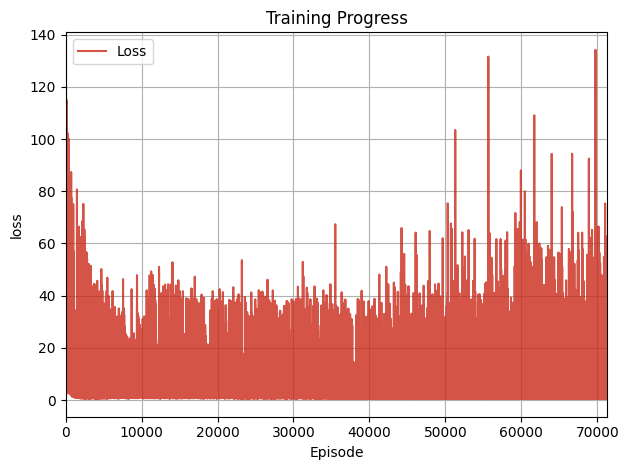

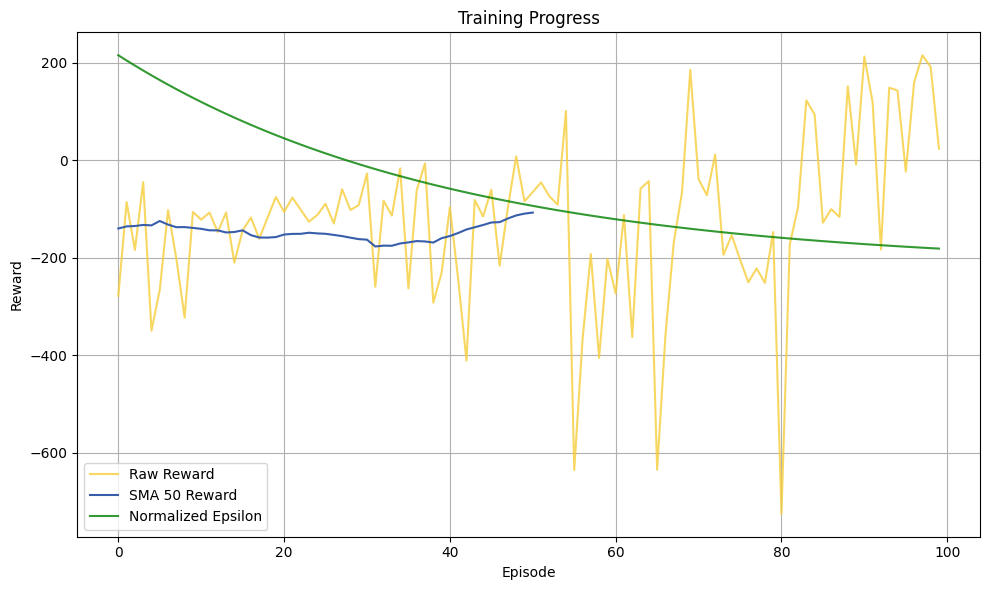

episode: 102/300, score: -15.981612450112323, e: 0.09126
episode: 103/300, score: 203.3279750435885, e: 0.08926
episode: 104/300, score: -11.488178944150448, e: 0.0873
episode: 105/300, score: -205.79259706098549, e: 0.08539
episode: 106/300, score: 23.640604398934585, e: 0.08353
episode: 107/300, score: -42.04664971844386, e: 0.08172
episode: 108/300, score: -229.71671530600386, e: 0.07994
episode: 109/300, score: -270.34417141156666, e: 0.07822
episode: 110/300, score: -233.9528979660646, e: 0.07653
episode: 111/300, score: 192.56811169982913, e: 0.07489
episode: 112/300, score: 173.2632324005197, e: 0.07329
episode: 113/300, score: 201.99364028246487, e: 0.07173
episode: 114/300, score: 261.3865771490145, e: 0.0702
episode: 115/300, score: 196.24859048494133, e: 0.06872
episode: 116/300, score: 181.9861197052788, e: 0.06727
episode: 117/300, score: 213.1899800227788, e: 0.06585
episode: 118/300, score: 56.65692606235636, e: 0.06447
episode: 119/300, score: -199.2415386869892, e: 0.0

In [6]:
loss_history=[]
class DQNAgent:
    def __init__(
        self, 
        env: gym.Env,
        batch_size: int,
        target_update: int,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        
        # CREATING THE Q-Network
        self.env = env
        self.action_space = env.action_space
        self.action_space.seed(seed)
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        self.batch_size = batch_size
        # hyper parameters
        memory_size = 100000
        self.lr = 0.001
        self.target_update = target_update
        self.gamma = 0.01
        
        self.dqn = Network(self.state_size, self.action_size)
        self.dqn_target = Network(self.state_size, self.action_size)
        self.train_start = 1000

        self.optimizers = optimizers.Adam(learning_rate=self.lr, )
        
        self.memory = deque(maxlen=memory_size)
        self.Soft_Update = False # use soft parameter update

        self.TAU = 0.1 # target network soft update hyperparameter
        
        self._target_hard_update()
        
    # EXPLORATION VS EXPLOITATION
    def get_action(self, state, epsilon):
        q_value = self.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
        # Choose an action a in the current world state (s)
        # If this number < greater than epsilon doing a random choice --> exploration
        if np.random.rand() <= epsilon:
            action = np.random.choice(self.action_size)

        ## Else --> exploitation (taking the biggest Q value for this state)
        else:
            action = np.argmax(q_value) 

        return action
    
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # UPDATING THE Q-VALUE
    def train_step(self):
        mini_batch = random.sample(self.memory, self.batch_size)

        states      = [i[0] for i in mini_batch]
        actions     = [i[1] for i in mini_batch]
        rewards     = [i[2] for i in mini_batch]
        next_states = [i[3] for i in mini_batch]
        dones       = [i[4] for i in mini_batch]
        
        dqn_variable = self.dqn.trainable_variables
        with tf.GradientTape() as tape:
            tape.watch(dqn_variable)
            
            states      = tf.convert_to_tensor(np.vstack(states), dtype=tf.float32)
            actions     = tf.convert_to_tensor(actions, dtype=tf.int32)
            rewards     = tf.convert_to_tensor(rewards, dtype=tf.float32)
            next_states = tf.convert_to_tensor(np.vstack(next_states), dtype=tf.float32)
            dones       = tf.convert_to_tensor(dones, dtype=tf.float32)
            
            next_Qs = self.dqn(next_states)
            next_Qs = tf.stop_gradient(next_Qs)
            next_Q_targs = self.dqn_target(next_states)
            next_action = tf.argmax(next_Qs, axis=1)
            target_value = tf.reduce_sum(tf.one_hot(next_action, self.action_size) * next_Q_targs, axis=1)
            
            mask = 1 - dones
            target_value = rewards + self.gamma * target_value * mask 
            
            curr_Qs = self.dqn(states)
            
            main_value = tf.reduce_sum(tf.one_hot(actions, self.action_size) * curr_Qs, axis=1)
            error = tf.square(main_value - target_value) * 0.5
            loss  = tf.reduce_mean(error)
            loss_history.append(loss)
            
        dqn_grads = tape.gradient(loss, dqn_variable)
        self.optimizers.apply_gradients(zip(dqn_grads, dqn_variable))
        
    # after some time interval update the target model to be same with model
    def _target_hard_update(self):
        if not self.Soft_Update:
            self.dqn_target.set_weights(self.dqn.get_weights())
            return
        if self.Soft_Update:
            q_model_theta = self.dqn.get_weights()
            dqn_target_theta = self.dqn_target.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, dqn_target_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                dqn_target_theta[counter] = target_weight
                counter += 1
            self.dqn_target.set_weights(dqn_target_theta)
    
    def update_Gamma(self):
        self.gamma = 1 - 0.96 * (1 - self.gamma)
    def load(self, phat):
        
        self.dqn = tf.keras.models.load_model(phat, custom_objects={'Network': Network})
    def save(self, phat):
        self.dqn.save(phat)

Train=True


env = gym.make("LunarLander-v2",render_mode="human" if not Train else None)

# parameters
target_update = 20


# INITIALIZING THE Q-PARAMETERS
hidden_size = 86
max_episodes = 300  # Set total number of episodes to train agent on.
batch_size =128#128

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.025            # Exponential decay rate for exploration prob

# train
agent = DQNAgent(
    env, 
#     memory_size, 
    batch_size, 
    target_update, 
#     epsilon_decay,
)
save_path='./weights-and-plot-G/final_weights'
load_path='./weights-and-plot-G/final_weights' + '_' + '300'
def plot_training(episode):
        agent.save(save_path + '_' + f'{episode}')
        print('\n~~~~~~Interval Save: Model saved.\n')
        sma_reward = np.convolve(reward_history, np.ones(50)/50, mode='valid')
        max_reward=np.max(reward_history)
        min_reward=np.min(reward_history)
        #normalized_loss = np.interp(loss_history, (np.min(loss_history), np.max(loss_history)), (min_reward/2,max_reward))
        normalized_epsilon = np.interp(epsilon_history, (np.min(epsilon_history), np.max(epsilon_history)), (min_reward/4,max_reward))
        plt.plot(loss_history, label='Loss', color='#CB291A', alpha=0.8)
        
        plt.title("Training Progress")
        plt.xlabel("Episode")
        plt.ylabel("loss")

        plt.xlim(0, len(loss_history))
        
        plt.legend()
        plt.grid(True)

        if episode == max_episodes:
            plt.savefig('./weights-and-plot-G/loss-of-training_progress.png', format='png', dpi=600, bbox_inches='tight')
            
        plt.tight_layout()
        plt.show()
        plt.clf()
        plt.close()

        plt.figure(figsize=(10, 6))
        
        #Plot Rewards,SMA 50 Reward ,Normalized Loss and Normalized Epsilon
        plt.plot(reward_history, label='Raw Reward', color='#F6CE3B', alpha=0.8)

        plt.plot(sma_reward, label='SMA 50 Reward', color='#385DAA')

        plt.plot(normalized_epsilon, label='Normalized Epsilon', color='green', alpha=0.8)
        
        #plt.plot(normalized_loss, label='Normalized Loss', color='#CB291A', alpha=0.8)
        
        plt.title("Training Progress")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()
        plt.grid(True)

        # Save as file if last episode
        if episode == max_episodes:
            plt.savefig('./weights-and-plot-G/training_progress.png', format='png', dpi=600, bbox_inches='tight')
            
        plt.tight_layout()
        plt.show()
        plt.clf()
        plt.close()
if __name__ == "__main__":
    
    save_intervalve=100
    if Train:

        update_cnt    = 0
        # TRAINING LOOP
        #List to contain all the rewards of all the episodes given to the agent
        scores = []
        reward_history=[]
        epsilon_history=[]
        # EACH EPISODE    
        for episode in range(1,max_episodes+1):
            ## Reset environment and get first new observation
            state = agent.env.reset(seed=1)
            state=state[0]
            episode_reward = 0
            done = False  # has the enviroment finished?
            step=0
                
            # EACH TIME STEP    
            while not done :

            # for step in range(max_steps):  # step index, maximum step is 200
                update_cnt += 1
                step +=1
                if step >=5000:
                    break
                # EXPLORATION VS EXPLOITATION
                # Take the action (a) and observe the outcome state(s') and reward (r)
                action = agent.get_action(state, epsilon)
            
                # TAKING ACTION
                next_state, reward, done, _ ,_= agent.env.step(action)
                if isinstance(state, tuple): 
                        next_state = next_state[0]
                agent.append_sample(state, action, reward, next_state, done)
                
                # Our new state is state
                state = next_state

                episode_reward += reward

                # if episode ends
                if done:
                    scores.append(episode_reward)
                    print("episode: {}/{}, score: {}, e: {:.4}".format(episode+1, max_episodes, episode_reward, epsilon,)) 
                    break
                # if training is ready
                if (update_cnt >= agent.batch_size):
                    # UPDATING THE Q-VALUE
                    agent.train_step()
                    
                
                    # if hard update is needed
                    if update_cnt % agent.target_update == 0:
                        agent._target_hard_update()
            agent.update_Gamma()
            reward_history.append(episode_reward)   
            epsilon_history.append(epsilon)
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
            
            if episode % save_intervalve==0:
                plot_training(episode)

    else:
        agent.load(load_path)
        scores = []
        for episode in range(5):
            state = agent.env.reset(seed=1)
            state=state[0]
            episode_reward = 0
            done = False  
            while not done:
                action = agent.get_action(state,0.01)
                next_state, reward, done, _ ,_= agent.env.step(action)
                if isinstance(state, tuple): 
                        next_state = next_state[0]
                agent.append_sample(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                if done:
                    scores.append(episode_reward)
                    print("episode: {}/{}, score: {}, e: {:.4}".format(episode+1, max_episodes, episode_reward, 0.01)) 
                    break
        pygame.quit()
        